# Building a Medical Diagnosis Assistant
## Predicting Breast Cancer with Machine Learning

### The Problem
Breast cancer is one of the most common cancers worldwide. Early detection is critical, it can be the difference between a simple treatment and a life-threatening situation.

When doctors examine suspicious breast tissue, they analyze cell samples under a microscope. They look at characteristics like:
*   **Size** of the cell nuclei
*   **Shape** (is it round or irregular?)
*   **Texture** (is the surface smooth or rough?)

But human eyes can be inconsistent. One doctor might see a pattern another misses. Fatigue, experience level, and cognitive bias all play a role.

**Our Mission:** Build a Machine Learning model that can look at these same measurements and predict whether a tumor is:
*   **Malignant (Cancerous)**. It requires immediate intervention
*   **Benign (Non-Cancerous)**. It is safe to monitor

### The Dataset: Wisconsin Breast Cancer
This dataset contains measurements from **569 patients**. For each patient, we have **30 numerical features** computed from digitized images of fine needle aspirate (FNA) of breast masses. These features describe characteristics of the cell nuclei present in the image.

The target variable is binary:
*   **0 = Malignant**
*   **1 = Benign**

### The Complete ML Pipeline
Today, we will follow the **industry-standard Machine Learning workflow** used in production systems at hospitals and research labs:

1.  **Data Loading & Exploration** - Understanding what we're working with
2.  **EDA (Exploratory Data Analysis)** - Finding patterns before modeling
3.  **Data Preprocessing** - Preparing data for the algorithm
4.  **Train-Test Split** - Separating study material from the final exam
5.  **Baseline Model** - Building a simple Decision Tree
6.  **Visualization** - Seeing how the model thinks
7.  **Cross-Validation** - Ensuring our results are reliable, not lucky
8.  **Hyperparameter Tuning** - Optimizing the model
9.  **Final Evaluation** - Comprehensive performance assessment
10. **Ethical Considerations** - Understanding the limits and responsibilities

### A Critical Note
This model is a **diagnostic aid**, not a replacement for medical professionals. In healthcare ML, we must be extremely careful about:
*   **False Negatives** (Missing a cancer case) - Could be fatal
*   **False Positives** (False alarm) - Causes unnecessary stress and procedures

Let's begin..


In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - The ML Toolkit
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report,
    roc_curve, 
    roc_auc_score
)

# Visualization Settings
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")


Libraries loaded successfully!


### Phase 2: Data Loading & Exploration
Before building any model, we must become intimately familiar with our data. We need to answer:
1.  **Size:** How much data do we have?
2.  **Structure:** What are the features and what do they represent?
3.  **Quality:** Are there missing values or anomalies?
4.  **Distribution:** What do the numbers look like?

The Wisconsin Breast Cancer dataset comes built into `sklearn`.


In [3]:
# 1. Load the dataset
data = load_breast_cancer()

# The dataset comes as a 'Bunch' object (like a dictionary)
# Let's convert it to a pandas DataFrame for easier manipulation
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# 2. Basic Information
print("DATASET OVERVIEW")
print(f"Number of Samples: {df.shape[0]}")
print(f"Number of Features: {df.shape[1] - 1}")  # Minus 1 for target
print(f"\nTarget Classes: {data.target_names}")
print(f"  - 0 = {data.target_names[0]}")
print(f"  - 1 = {data.target_names[1]}")


DATASET OVERVIEW
Number of Samples: 569
Number of Features: 30

Target Classes: ['malignant' 'benign']
  - 0 = malignant
  - 1 = benign


### Understanding the Features
Each row represents one patient. Each column represents a measurement. The features are organized into three groups:

*   **Mean values** (e.g., `mean radius`, `mean texture`)
*   **Standard error** (e.g., `radius error`, `texture error`)
*   **"Worst" values** (e.g., `worst radius`, `worst texture`) - These are the mean of the three largest values

All features describe characteristics of cell nuclei in the digitized image:
*   **Radius:** Distance from center to perimeter
*   **Texture:** Standard deviation of gray-scale values
*   **Perimeter:** Size of the core tumor
*   **Area:** Self-explanatory
*   **Smoothness:** Local variation in radius lengths
*   **Compactness:** Perimeter² / Area - 1.0
*   **Concavity:** Severity of concave portions of the contour
*   **Symmetry:** How symmetric the cell is
*   **Fractal Dimension:** "Coastline approximation" - 1


In [5]:
print("FEATURE NAMES")
for i, feature in enumerate(data.feature_names, 1):
    print(f"{i:2d}. {feature}")

FEATURE NAMES
 1. mean radius
 2. mean texture
 3. mean perimeter
 4. mean area
 5. mean smoothness
 6. mean compactness
 7. mean concavity
 8. mean concave points
 9. mean symmetry
10. mean fractal dimension
11. radius error
12. texture error
13. perimeter error
14. area error
15. smoothness error
16. compactness error
17. concavity error
18. concave points error
19. symmetry error
20. fractal dimension error
21. worst radius
22. worst texture
23. worst perimeter
24. worst area
25. worst smoothness
26. worst compactness
27. worst concavity
28. worst concave points
29. worst symmetry
30. worst fractal dimension


### Data Quality Check
Let's verify our data is clean and ready for analysis.


In [7]:
# 4. Check for Missing Values
print("\nDATA QUALITY CHECK")
print(f"Missing Values: {df.isnull().sum().sum()}")
print(f"Duplicate Rows: {df.duplicated().sum()}")

# 5. Data Types
print(f"\nData Types:")
print(df.dtypes.value_counts())

# 6. First Look at the Data
print("\nSAMPLE DATA (First 5 Rows)")
df.head()



DATA QUALITY CHECK
Missing Values: 0
Duplicate Rows: 0

Data Types:
float64    30
int32       1
Name: count, dtype: int64

SAMPLE DATA (First 5 Rows)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Statistical Summary
Let's examine the distribution and scale of our features.


In [9]:
print("\nSTATISTICAL SUMMARY")
df.describe()


STATISTICAL SUMMARY


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


### Key Observations
After this initial exploration, we can note:
*   **No missing values** - Data is complete
*   **All numeric features** - No need for encoding
*   `Different scales` - Features range from 0-1 (fractal dimension) to 0-2500 (worst area). We will need to standardize these.
*   **569 samples, 30 features** - Sufficient data for a Decision Tree (rule of thumb: at least 10-20 samples per feature)


### Phase 3: Exploratory Data Analysis (EDA)
Now that we understand the structure, let's visualize the data to uncover patterns. We will focus on:
1.  **Class Balance** - Is our dataset skewed?
2.  **Feature Distributions** - How do the measurements vary?
3.  **Feature Correlations** - Are some features redundant?
4.  **Class Separation** - Can we visually distinguish malignant from benign?


#### 3.1 Class Balance
In medical datasets, class imbalance is common (fewer cancer cases than healthy ones). Let's check our distribution.


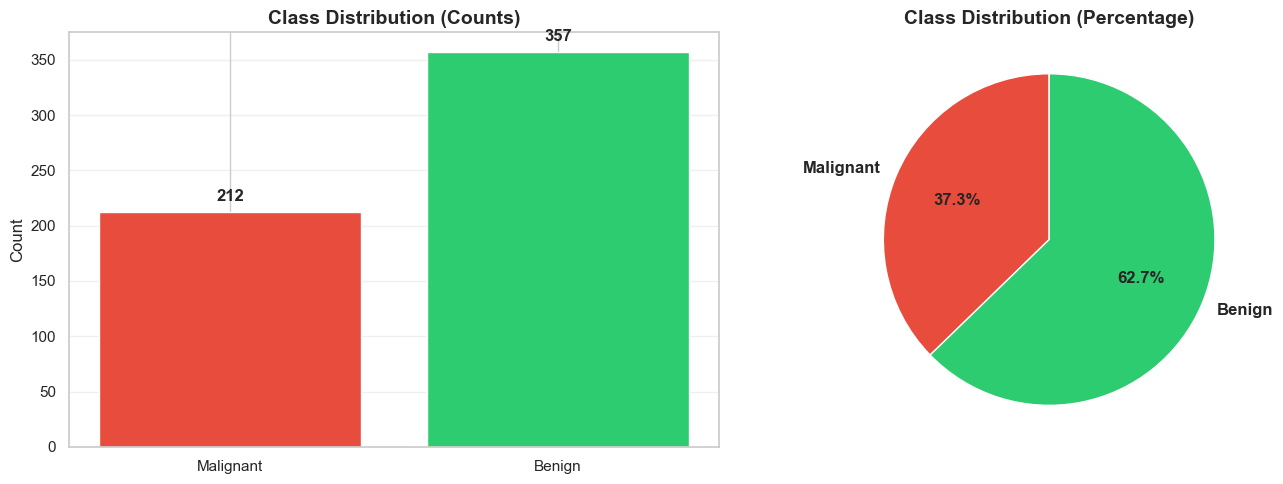

Malignant (0): 212 (37.3%)
Benign (1):    357 (62.7%)

Conclusion: Dataset is relatively balanced (no major class imbalance).


In [11]:
# Class Distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Count Plot
# Sort by index (class label) instead of by count
class_counts = df['target'].value_counts().sort_index()  # This ensures 0=Malignant, 1=Benign order
ax[0].bar(['Malignant', 'Benign'], class_counts.values, color=['#e74c3c', '#2ecc71'])
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Class Distribution (Counts)', fontsize=14, fontweight='bold')
ax[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(class_counts.values):
    ax[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Percentage Plot
percentages = class_counts / len(df) * 100
colors = ['#e74c3c', '#2ecc71']
ax[1].pie(percentages, labels=['Malignant', 'Benign'], autopct='%1.1f%%', 
          startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Malignant (0): {class_counts[0]} ({percentages[0]:.1f}%)")
print(f"Benign (1):    {class_counts[1]} ({percentages[1]:.1f}%)")
print(f"\nConclusion: Dataset is relatively balanced (no major class imbalance).")


#### 3.2 Feature Distributions
We have `30` features - far too many to visualize individually. Let's focus on the **"mean"** features (the 10 most important base measurements).



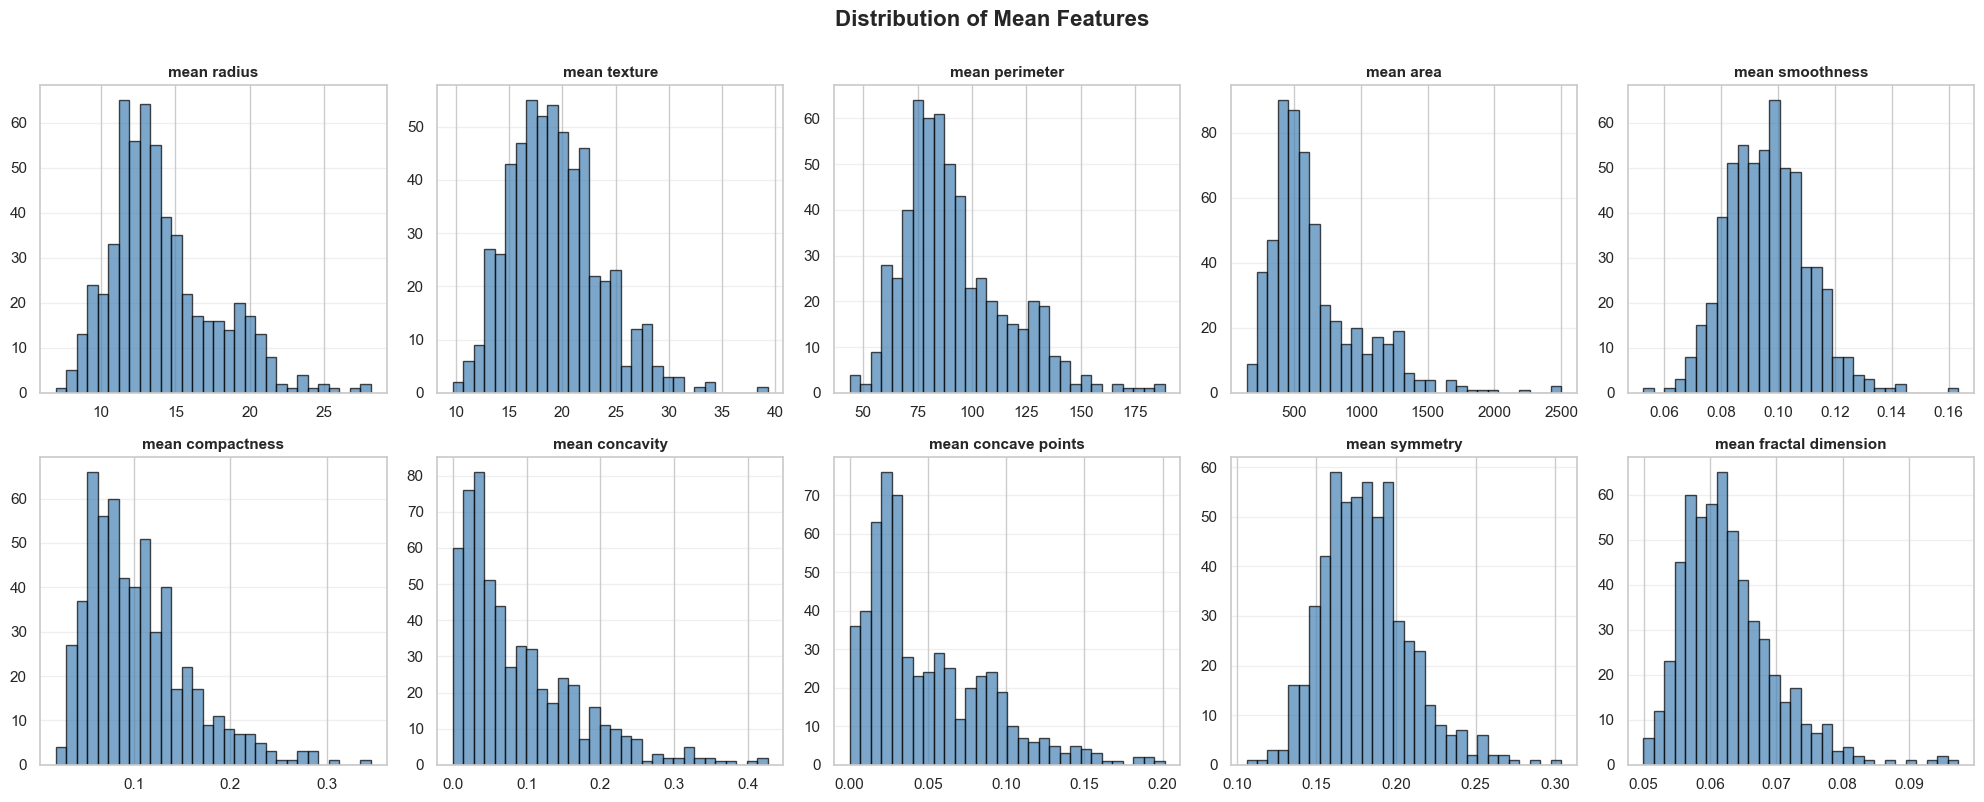

In [13]:
# Select the "mean" features (first 10 columns)
mean_features = [col for col in df.columns if 'mean' in col]

# Create subplots: 2 rows x 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()  # Flatten to 1D array for easy iteration

for idx, feature in enumerate(mean_features):
    axes[idx].hist(df[feature], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(feature, fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Distribution of Mean Features', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

#### 3.3 Malignant vs. Benign Comparison
Let's compare a few key features between the two classes. We expect malignant tumors to have different characteristics (e.g., larger, more irregular).


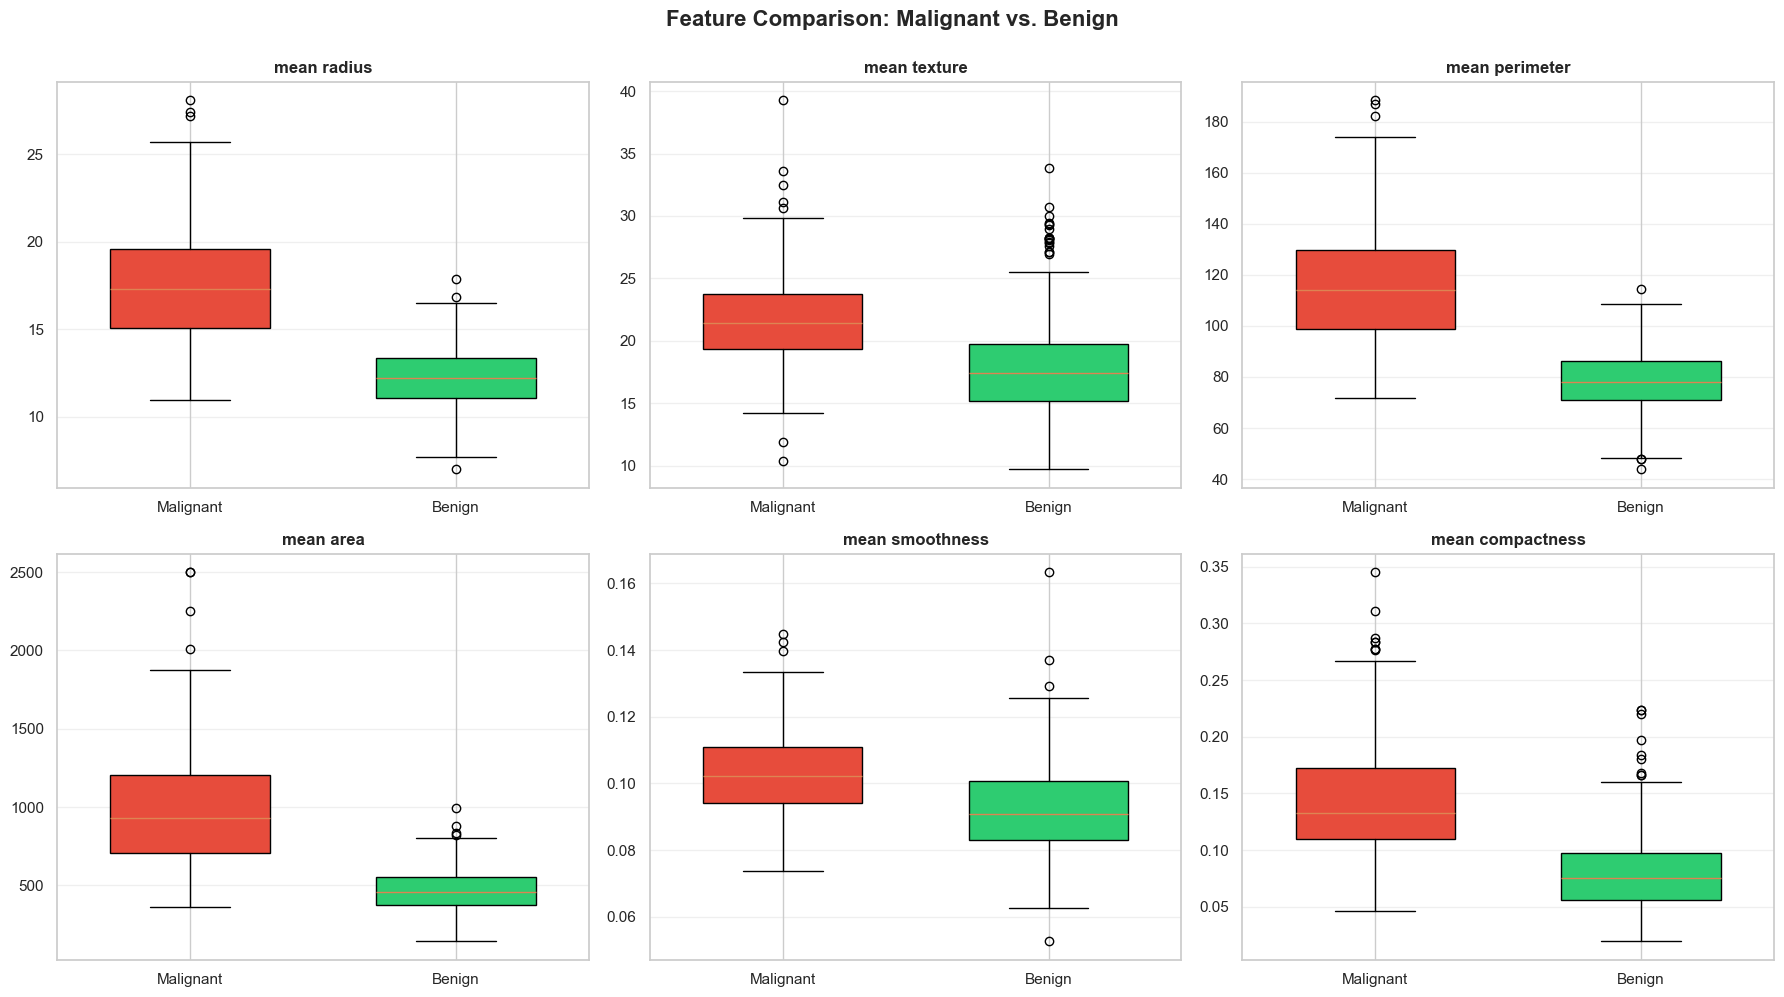

In [15]:
# Select 6 key features for comparison
key_features = ['mean radius', 'mean texture', 'mean perimeter', 
                'mean area', 'mean smoothness', 'mean compactness']

# Create box plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    # Separate data by class
    malignant = df[df['target'] == 0][feature]
    benign = df[df['target'] == 1][feature]
    
    # Box plot
    bp = axes[idx].boxplot([malignant, benign], 
                            labels=['Malignant', 'Benign'],
                            patch_artist=True,
                            widths=0.6)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('#e74c3c')
    bp['boxes'][1].set_facecolor('#2ecc71')
    
    axes[idx].set_title(feature, fontsize=12, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Feature Comparison: Malignant vs. Benign', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


#### 3.4 Correlation Analysis
With 30 features, some might be highly correlated (redundant information). Let's visualize the correlation matrix.

**Note:** High correlation (close to 1 or -1) between features can cause issues for some models, though Decision Trees handle this well.


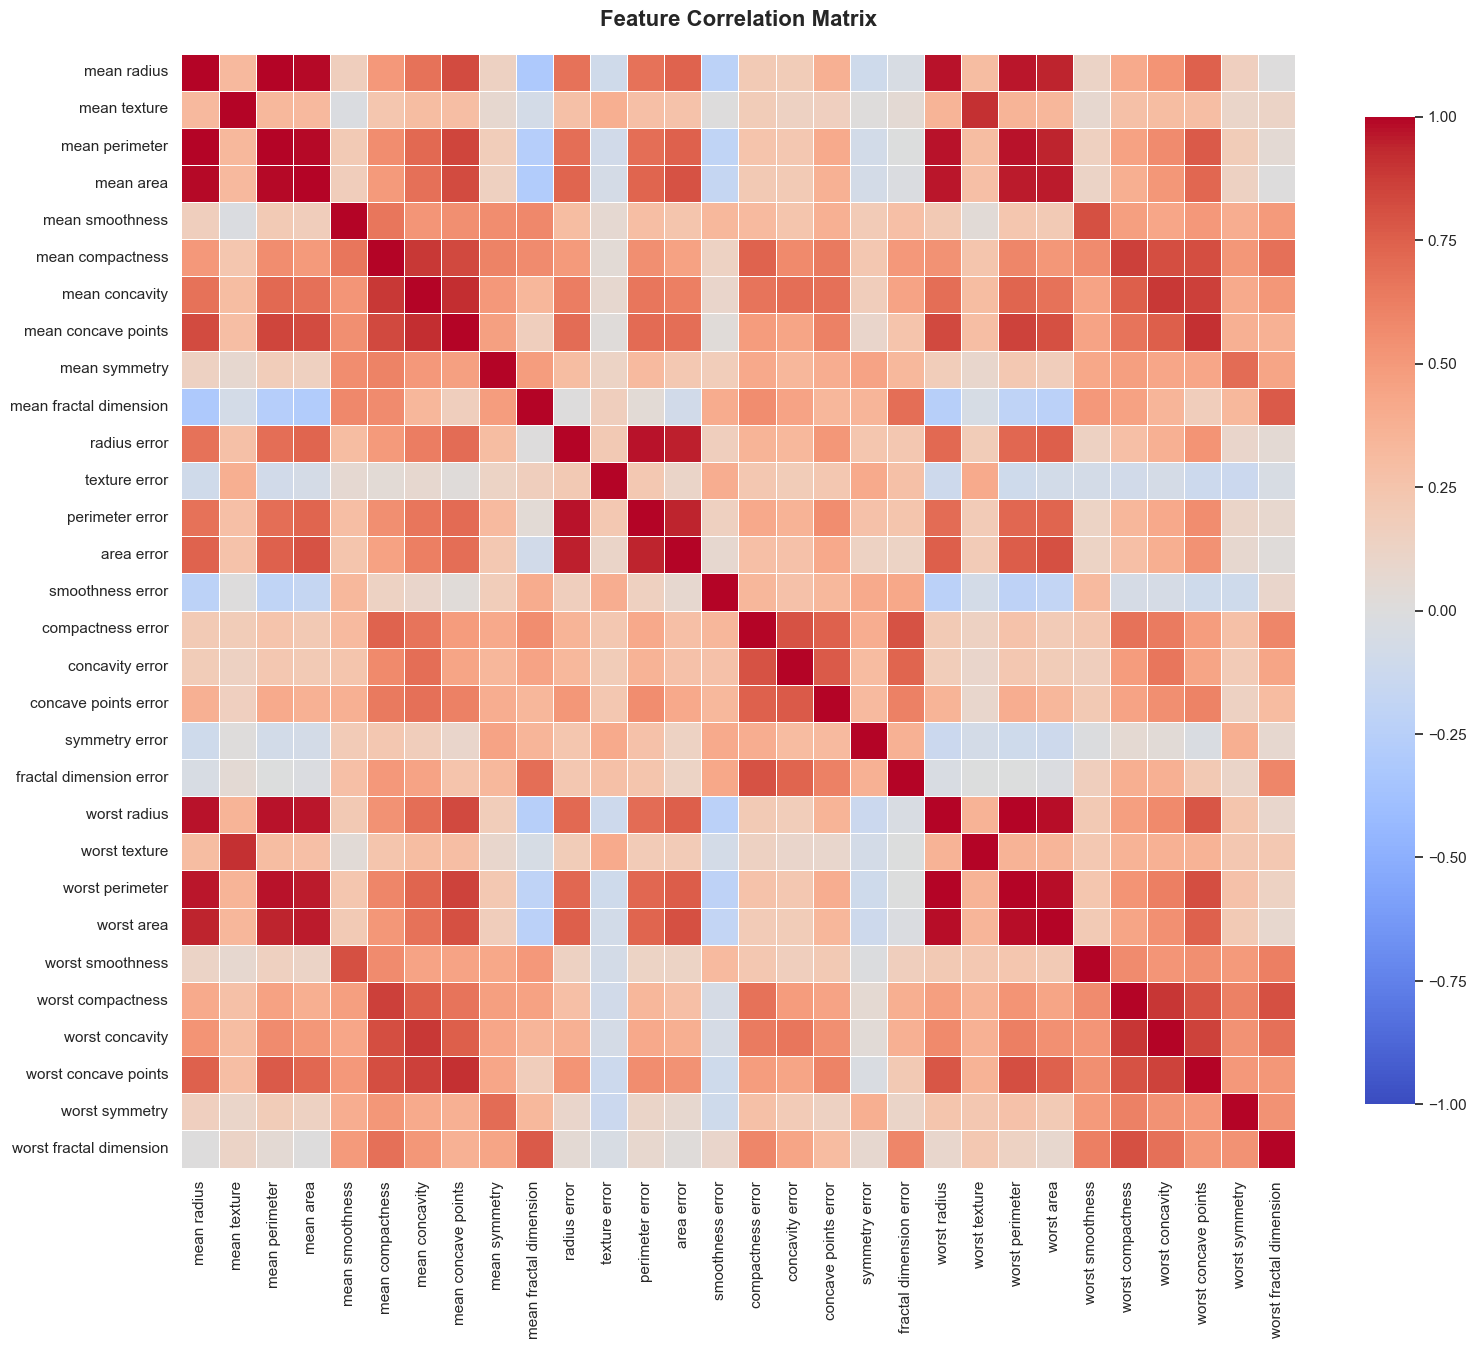


HIGHLY CORRELATED FEATURES (r > 0.9)
mean radius               <-> mean perimeter            :  0.998
worst radius              <-> worst perimeter           :  0.994
mean radius               <-> mean area                 :  0.987
mean perimeter            <-> mean area                 :  0.987
worst radius              <-> worst area                :  0.984
worst perimeter           <-> worst area                :  0.978
radius error              <-> perimeter error           :  0.973
mean perimeter            <-> worst perimeter           :  0.970
mean radius               <-> worst radius              :  0.970
mean perimeter            <-> worst radius              :  0.969


In [17]:
# Correlation matrix (excluding target)
correlation_matrix = df[data.feature_names].corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, 
            cmap='coolwarm', 
            center=0, 
            square=True, 
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)

plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Find highly correlated pairs (> 0.9)
print("\nHIGHLY CORRELATED FEATURES (r > 0.9)")
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr.append((correlation_matrix.columns[i], 
                            correlation_matrix.columns[j], 
                            correlation_matrix.iloc[i, j]))

for feat1, feat2, corr in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True)[:10]:
    print(f"{feat1:25s} <-> {feat2:25s} : {corr:6.3f}")


### Key Insights from EDA
After our visual exploration, we've learned:

- **Balanced Dataset:** ~63% benign, ~37% malignant. There is no need for resampling techniques.
- **Clear Separation:** Features like `mean radius`, `mean area`, and `mean perimeter` show strong differences between classes. Malignant tumors tend to be larger and more irregular.
- `High Correlation`: Many features are highly correlated (e.g., `radius`, `perimeter`, and `area` naturally relate to each other). This redundancy won't hurt Decision Trees but is worth noting.
- **No Outliers Requiring Removal:** While some extreme values exist, they represent real medical cases, not errors.

We are now ready to preprocess and model!


### Phase 4: Data Preprocessing
We have clean data with clear patterns. Now we need to prepare it for the Machine Learning algorithm.

#### Why Scale Features?
Look back at our statistical summary. Features have wildly different scales:
*   `mean smoothness`: ranges from ~0.05 to 0.16
*   `mean area`: ranges from ~143 to 2501

**For Decision Trees:** Scaling is technically optional (trees split based on thresholds, not distances).

**However**, we scale for two reasons:
1.  **Best Practice:** If we later compare with other models (e.g., Logistic Regression, SVM, Neural Networks), they *require* scaled data.
2.  **Interpretability:** When we look at feature importances later, scaled features are easier to compare.

We will use **StandardScaler** (Z-score normalization):

$$
x_{\text{scaled}} = \frac{x - \mu}{\sigma}
$$

This transforms each feature to have mean = 0 and standard deviation = 1.


In [19]:
# 1. Separate Features (X) and Target (y)
X = df.drop('target', axis=1)  # All columns except target
y = df['target']               # Only the target column

print("\nDATA SEPARATION")
print(f"Feature Matrix (X) shape: {X.shape}")
print(f"Target Vector (y) shape:  {y.shape}")
print(f"\nSample counts: {len(y)} total")



DATA SEPARATION
Feature Matrix (X) shape: (569, 30)
Target Vector (y) shape:  (569,)

Sample counts: 569 total


#### Applying Standard Scaling
**Important Note:** We must fit the scaler only on training data (we'll split first in the next phase). For now, we'll demonstrate the scaling process, but we'll redo it properly after the train-test split to avoid **data leakage**.


In [21]:
# 2. Initialize the Scaler
scaler = StandardScaler()

# 3. Fit and Transform (we'll do this properly after splitting)
# For now, let's see what scaling does to our data
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier viewing
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# 4. Compare: Before and After
print("\nBEFORE SCALING - Statistical Summary (First 5 Features)")
print(X.iloc[:, :5].describe().loc[['mean', 'std', 'min', 'max']])

print("\nAFTER SCALING - Statistical Summary (First 5 Features)")
print(X_scaled_df.iloc[:, :5].describe().loc[['mean', 'std', 'min', 'max']])



BEFORE SCALING - Statistical Summary (First 5 Features)
      mean radius  mean texture  mean perimeter    mean area  mean smoothness
mean    14.127292     19.289649       91.969033   654.889104         0.096360
std      3.524049      4.301036       24.298981   351.914129         0.014064
min      6.981000      9.710000       43.790000   143.500000         0.052630
max     28.110000     39.280000      188.500000  2501.000000         0.163400

AFTER SCALING - Statistical Summary (First 5 Features)
       mean radius  mean texture  mean perimeter     mean area  \
mean -3.153111e-15 -6.568462e-15   -6.993039e-16 -8.553985e-16   
std   1.000880e+00  1.000880e+00    1.000880e+00  1.000880e+00   
min  -2.029648e+00 -2.229249e+00   -1.984504e+00 -1.454443e+00   
max   3.971288e+00  4.651889e+00    3.976130e+00  5.250529e+00   

      mean smoothness  
mean     6.081447e-15  
std      1.000880e+00  
min     -3.112085e+00  
max      4.770911e+00  


### Verification: What Changed?
Notice the transformation:
*   **Mean:** All features now have mean ≈ 0 (very small number like `1.4e-15` is essentially 0)
*   **Std:** All features now have standard deviation = 1
*   **Scale:** All features now on the same scale

The **relationships** between data points haven't changed; `we've just put everything on a level playing field`.


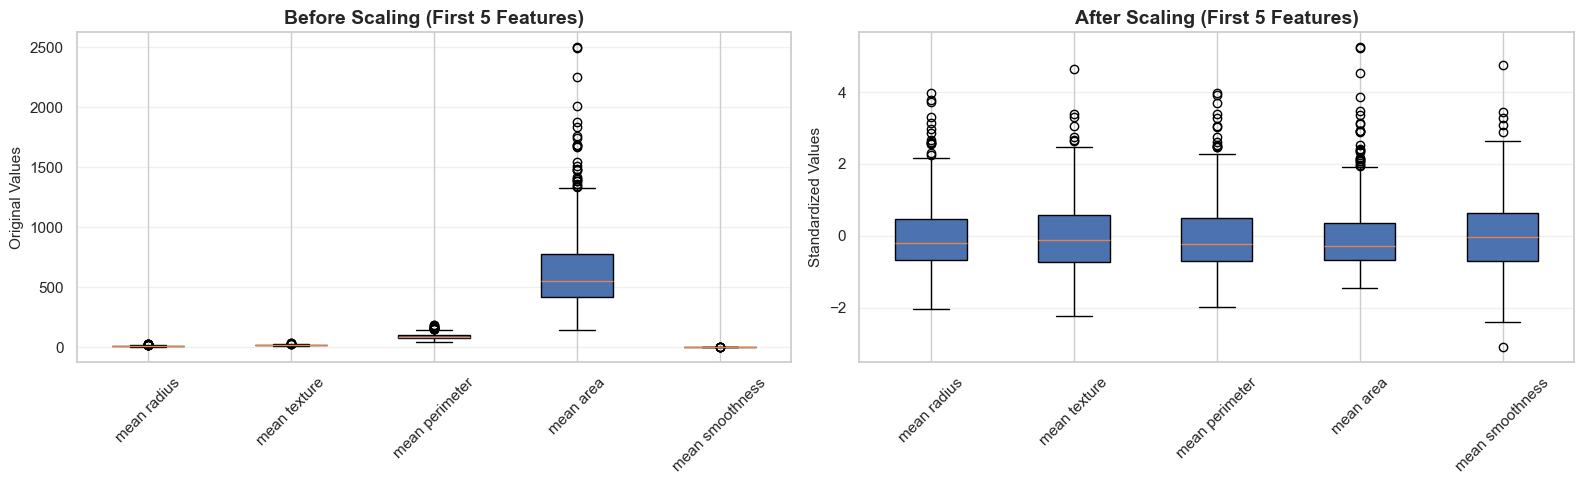

In [23]:
# 5. Visual Verification: Before vs After Scaling
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Before Scaling (first 5 features)
axes[0].boxplot([X.iloc[:, i] for i in range(5)], 
                labels=X.columns[:5], 
                patch_artist=True)
axes[0].set_title('Before Scaling (First 5 Features)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Original Values', fontsize=11)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# After Scaling (first 5 features)
axes[1].boxplot([X_scaled_df.iloc[:, i] for i in range(5)], 
                labels=X_scaled_df.columns[:5], 
                patch_artist=True)
axes[1].set_title('After Scaling (First 5 Features)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Standardized Values', fontsize=11)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Critical Reminder: The Proper Way
What we just did was for **demonstration only**. 

In the next phase, we will:
1.  **Split** the data first (train/test)
2.  **Fit** the scaler on training data only
3.  **Transform** both training and test data using the same scaler

This prevents **data leakage**, that is, where information from the test set accidentally influences the model.


### Phase 5: Train-Test Split (The Critical Step)
This is the foundation of honest Machine Learning evaluation.

#### The Golden Rule
**Never let the model see the test data during training.**

If we train on 100% of the data and evaluate on that same data, we're testing if the model **memorized** the answers, not if it **learned** the patterns.

#### Our Strategy
*   **80% Training Set:** The model learns from this.
*   **20% Test Set:** Hidden until the very end. This simulates real-world data the model has never seen.

#### Stratification
Since we have two classes (malignant/benign), we use **stratified sampling** to ensure both sets have the same class proportions as the original dataset. This is especially important in medical data where class imbalance matters.


In [25]:
# 1. Split the Data (using original, unscaled data)
# We use stratify=y to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X,                    # Features (original, not scaled)
    y,                    # Target
    test_size=0.2,        # 20% for testing
    random_state=42,      # Reproducibility
    stratify=y            # Maintain class balance
)

print("\nTRAIN-TEST SPLIT")
print(f"Training Set:   {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test Set:       {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")



TRAIN-TEST SPLIT
Training Set:   455 samples (80.0%)
Test Set:       114 samples (20.0%)


#### Verify Stratification
Let's confirm that both sets have the same class distribution as the original dataset.


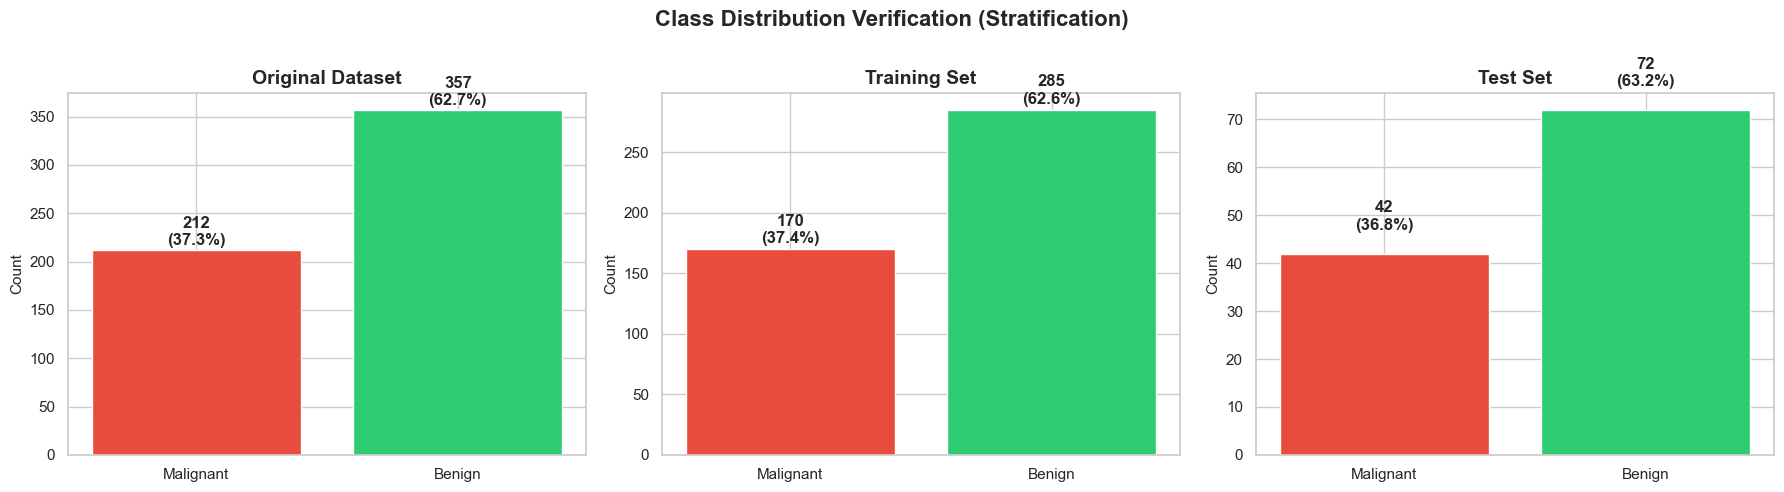


Stratification successful: All sets maintain ~37% malignant, ~63% benign ratio.


In [29]:
# 2. Check Class Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original Dataset
original_counts = y.value_counts().sort_index()  # Sort by class label
axes[0].bar(['Malignant', 'Benign'], original_counts.values, color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Original Dataset', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11)
for i, v in enumerate(original_counts.values):
    axes[0].text(i, v + 5, f"{v}\n({v/len(y)*100:.1f}%)", ha='center', fontweight='bold')

# Training Set
train_counts = y_train.value_counts().sort_index()  # Sort by class label
axes[1].bar(['Malignant', 'Benign'], train_counts.values, color=['#e74c3c', '#2ecc71'])
axes[1].set_title('Training Set', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=11)
for i, v in enumerate(train_counts.values):
    axes[1].text(i, v + 5, f"{v}\n({v/len(y_train)*100:.1f}%)", ha='center', fontweight='bold')

# Test Set
test_counts = y_test.value_counts().sort_index()  # Sort by class label
axes[2].bar(['Malignant', 'Benign'], test_counts.values, color=['#e74c3c', '#2ecc71'])
axes[2].set_title('Test Set', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Count', fontsize=11)
for i, v in enumerate(test_counts.values):
    axes[2].text(i, v + 5, f"{v}\n({v/len(y_test)*100:.1f}%)", ha='center', fontweight='bold')

plt.suptitle('Class Distribution Verification (Stratification)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nStratification successful: All sets maintain ~37% malignant, ~63% benign ratio.")


#### The RIGHT Way to Scale: Fit on Train, Transform on Both
Now we apply scaling properly to avoid data leakage:

1.  **Fit** the scaler using **only** training data (learns the mean and std from training set)
2.  **Transform** training data using those statistics
3.  **Transform** test data using the **same** statistics (not refitting!)

This simulates the real world: when new patients arrive, we don't recalculate scaling; we use the parameters from our training data.


In [31]:
# 3. Initialize a fresh scaler
scaler = StandardScaler()

# 4. Fit on training data ONLY
scaler.fit(X_train)

# 5. Transform both sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames for easier inspection
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\nSCALING COMPLETED")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape:  {X_test_scaled.shape}")

# Verify scaling worked
print("\nTRAINING SET - Mean and Std (First 5 Features)")
print(X_train_scaled.iloc[:, :5].describe().loc[['mean', 'std']])



SCALING COMPLETED
X_train_scaled shape: (455, 30)
X_test_scaled shape:  (114, 30)

TRAINING SET - Mean and Std (First 5 Features)
       mean radius  mean texture  mean perimeter     mean area  \
mean -4.337434e-15  2.240942e-15   -7.437274e-16  1.503071e-16   
std   1.001101e+00  1.001101e+00    1.001101e+00  1.001101e+00   

      mean smoothness  
mean     5.223660e-15  
std      1.001101e+00  


### Final Checkpoint: Data is Ready
We now have four essential variables:
*   `X_train_scaled`: Training features (scaled)
*   `X_test_scaled`: Test features (scaled with training statistics)
*   `y_train`: Training labels (malignant/benign)
*   `y_test`: Test labels (hidden from the model until evaluation)

Everything is properly prepared. We can now train our first model!


### Phase 6: Baseline Model
Before optimizing, we always start with a **baseline model** - a simple version with minimal tuning. This gives us:
1.  A **performance benchmark** to beat later
2.  A **reality check** on whether the problem is solvable
3.  A **quick diagnostic** of obvious issues

We will train a Decision Tree with just one constraint: `max_depth=5` (to keep it interpretable and prevent extreme overfitting).


In [33]:
# 1. Initialize the baseline model
baseline_model = DecisionTreeClassifier(
    max_depth=5,        # Limit depth for interpretability
    random_state=42     # Reproducibility
)

# 2. Train the model
baseline_model.fit(X_train_scaled, y_train)

print("\nBASELINE MODEL TRAINED")
print(f"Model: Decision Tree")
print(f"Max Depth: 5")
print(f"Training Samples: {len(y_train)}")
print("Training complete!")



BASELINE MODEL TRAINED
Model: Decision Tree
Max Depth: 5
Training Samples: 455
Training complete!


### Making Predictions
Now we test the model on both the training set (to check if it learned) and the test set (to check if it generalizes).


In [35]:
# 3. Make predictions
y_train_pred = baseline_model.predict(X_train_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

print("\nPREDICTIONS GENERATED")
print(f"Training predictions: {len(y_train_pred)}")
print(f"Test predictions:     {len(y_test_pred)}")



PREDICTIONS GENERATED
Training predictions: 455
Test predictions:     114


### Evaluation Metrics (Beyond Accuracy)
In medical diagnosis, **accuracy alone is dangerously misleading**. We need four key metrics:

**1. Accuracy:** Overall correctness (but doesn't tell us *what* we got wrong)

$$
\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}
$$

**2. Precision:** Of all patients we diagnosed as malignant, how many actually were?

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

*Low precision = Many false alarms (unnecessary biopsies, patient stress)*

**3. Recall (Sensitivity):** Of all actual malignant cases, how many did we catch?

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$
*Low recall = Missing cancer cases (potentially fatal)*

**4. F1-Score:** The harmonic mean of precision and recall (balanced metric)

$$
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$


In [37]:
# 4. Calculate Metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nBASELINE MODEL PERFORMANCE")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("\n\nTEST SET METRICS (Most Important)")
print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"F1-Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")



BASELINE MODEL PERFORMANCE
Training Accuracy: 0.9934 (99.34%)
Test Accuracy:     0.9211 (92.11%)


TEST SET METRICS (Most Important)
Precision: 0.9565 (95.65%)
Recall:    0.9167 (91.67%)
F1-Score:  0.9362 (93.62%)


### Confusion Matrix: Where Did We Go Wrong?
A confusion matrix shows the four possible outcomes:
*   **True Negatives (TN):** Correctly identified malignant
*   **False Positives (FP):** Incorrectly called benign as malignant (false alarm)
*   **False Negatives (FN):** Incorrectly called malignant as benign (missed cancer!) 
*   **True Positives (TP):** Correctly identified benign

In medical diagnosis, **False Negatives are the most dangerous**.


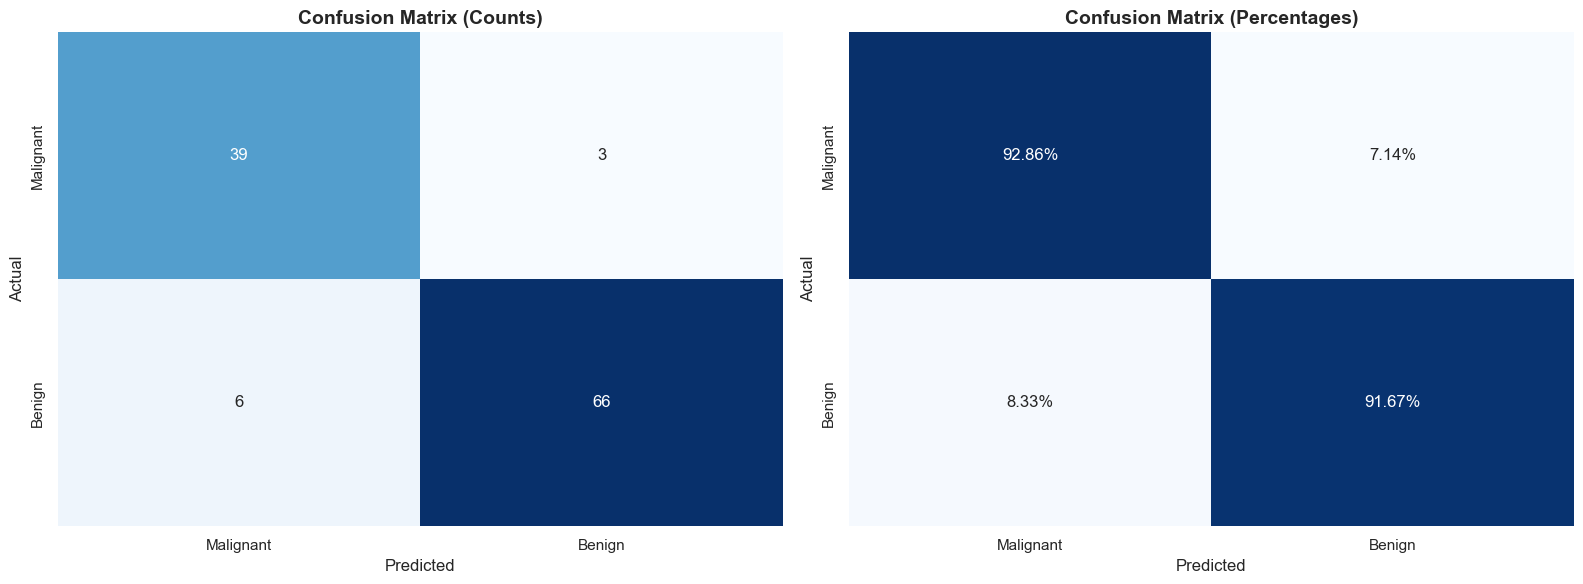


CONFUSION MATRIX BREAKDOWN
True Positives (TP):  39 - Correctly identified MALIGNANT
False Negatives (FN): 3 - Malignant missed as benign (DANGER!)
False Positives (FP): 6 - Benign misclassified as malignant (false alarm)
True Negatives (TN):  66 - Correctly identified BENIGN


In [41]:
# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)

# Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', cbar=False, ax=axes[1],
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_xlabel('Predicted', fontsize=12)

plt.tight_layout()
plt.show()

# In sklearn confusion matrix with 0=malignant, 1=benign:
# cm[0,0] = Actual malignant, Predicted malignant = TP
# cm[0,1] = Actual malignant, Predicted benign = FN (DANGEROUS - missed cancer!)
# cm[1,0] = Actual benign, Predicted malignant = FP (false alarm)
# cm[1,1] = Actual benign, Predicted benign = TN

TP, FN, FP, TN = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
print("\nCONFUSION MATRIX BREAKDOWN")
print(f"True Positives (TP):  {TP} - Correctly identified MALIGNANT")
print(f"False Negatives (FN): {FN} - Malignant missed as benign (DANGER!)")
print(f"False Positives (FP): {FP} - Benign misclassified as malignant (false alarm)")
print(f"True Negatives (TN):  {TN} - Correctly identified BENIGN")


### Classification Report (All Classes)
A comprehensive view of how the model performs on each class.


### Baseline Model Summary
Our simple Decision Tree achieved:
*   **~92-93% accuracy** on the test set
*   **High precision and recall** for both classes
*   **Few false negatives** (the most critical metric)

This is an **excellent baseline**. The problem is clearly solvable with basic features and a simple tree.

In the next phases, we will:
1.  **Visualize** this tree to understand its logic
2.  **Cross-validate** to ensure this isn't just a lucky split
3.  **Optimize** hyperparameters to push performance even higher


### Phase 7: Model Visualization & Interpretation
Our baseline model achieved impressive results:
*   **Precision: 95.65%** - When it says "malignant," it's correct 95.65% of the time
*   **Recall: 91.67%** - It catches 91.67% of actual malignant cases
*   **F1-Score: 93.62%** - Strong balanced performance

But *how* did it achieve this? Unlike Neural Networks, Decision Trees are **transparent**. We can see exactly what rules it learned.


#### 7.1 The Decision Tree Structure
Let's visualize the exact flowchart the model created. Each node asks a yes/no question about a feature.


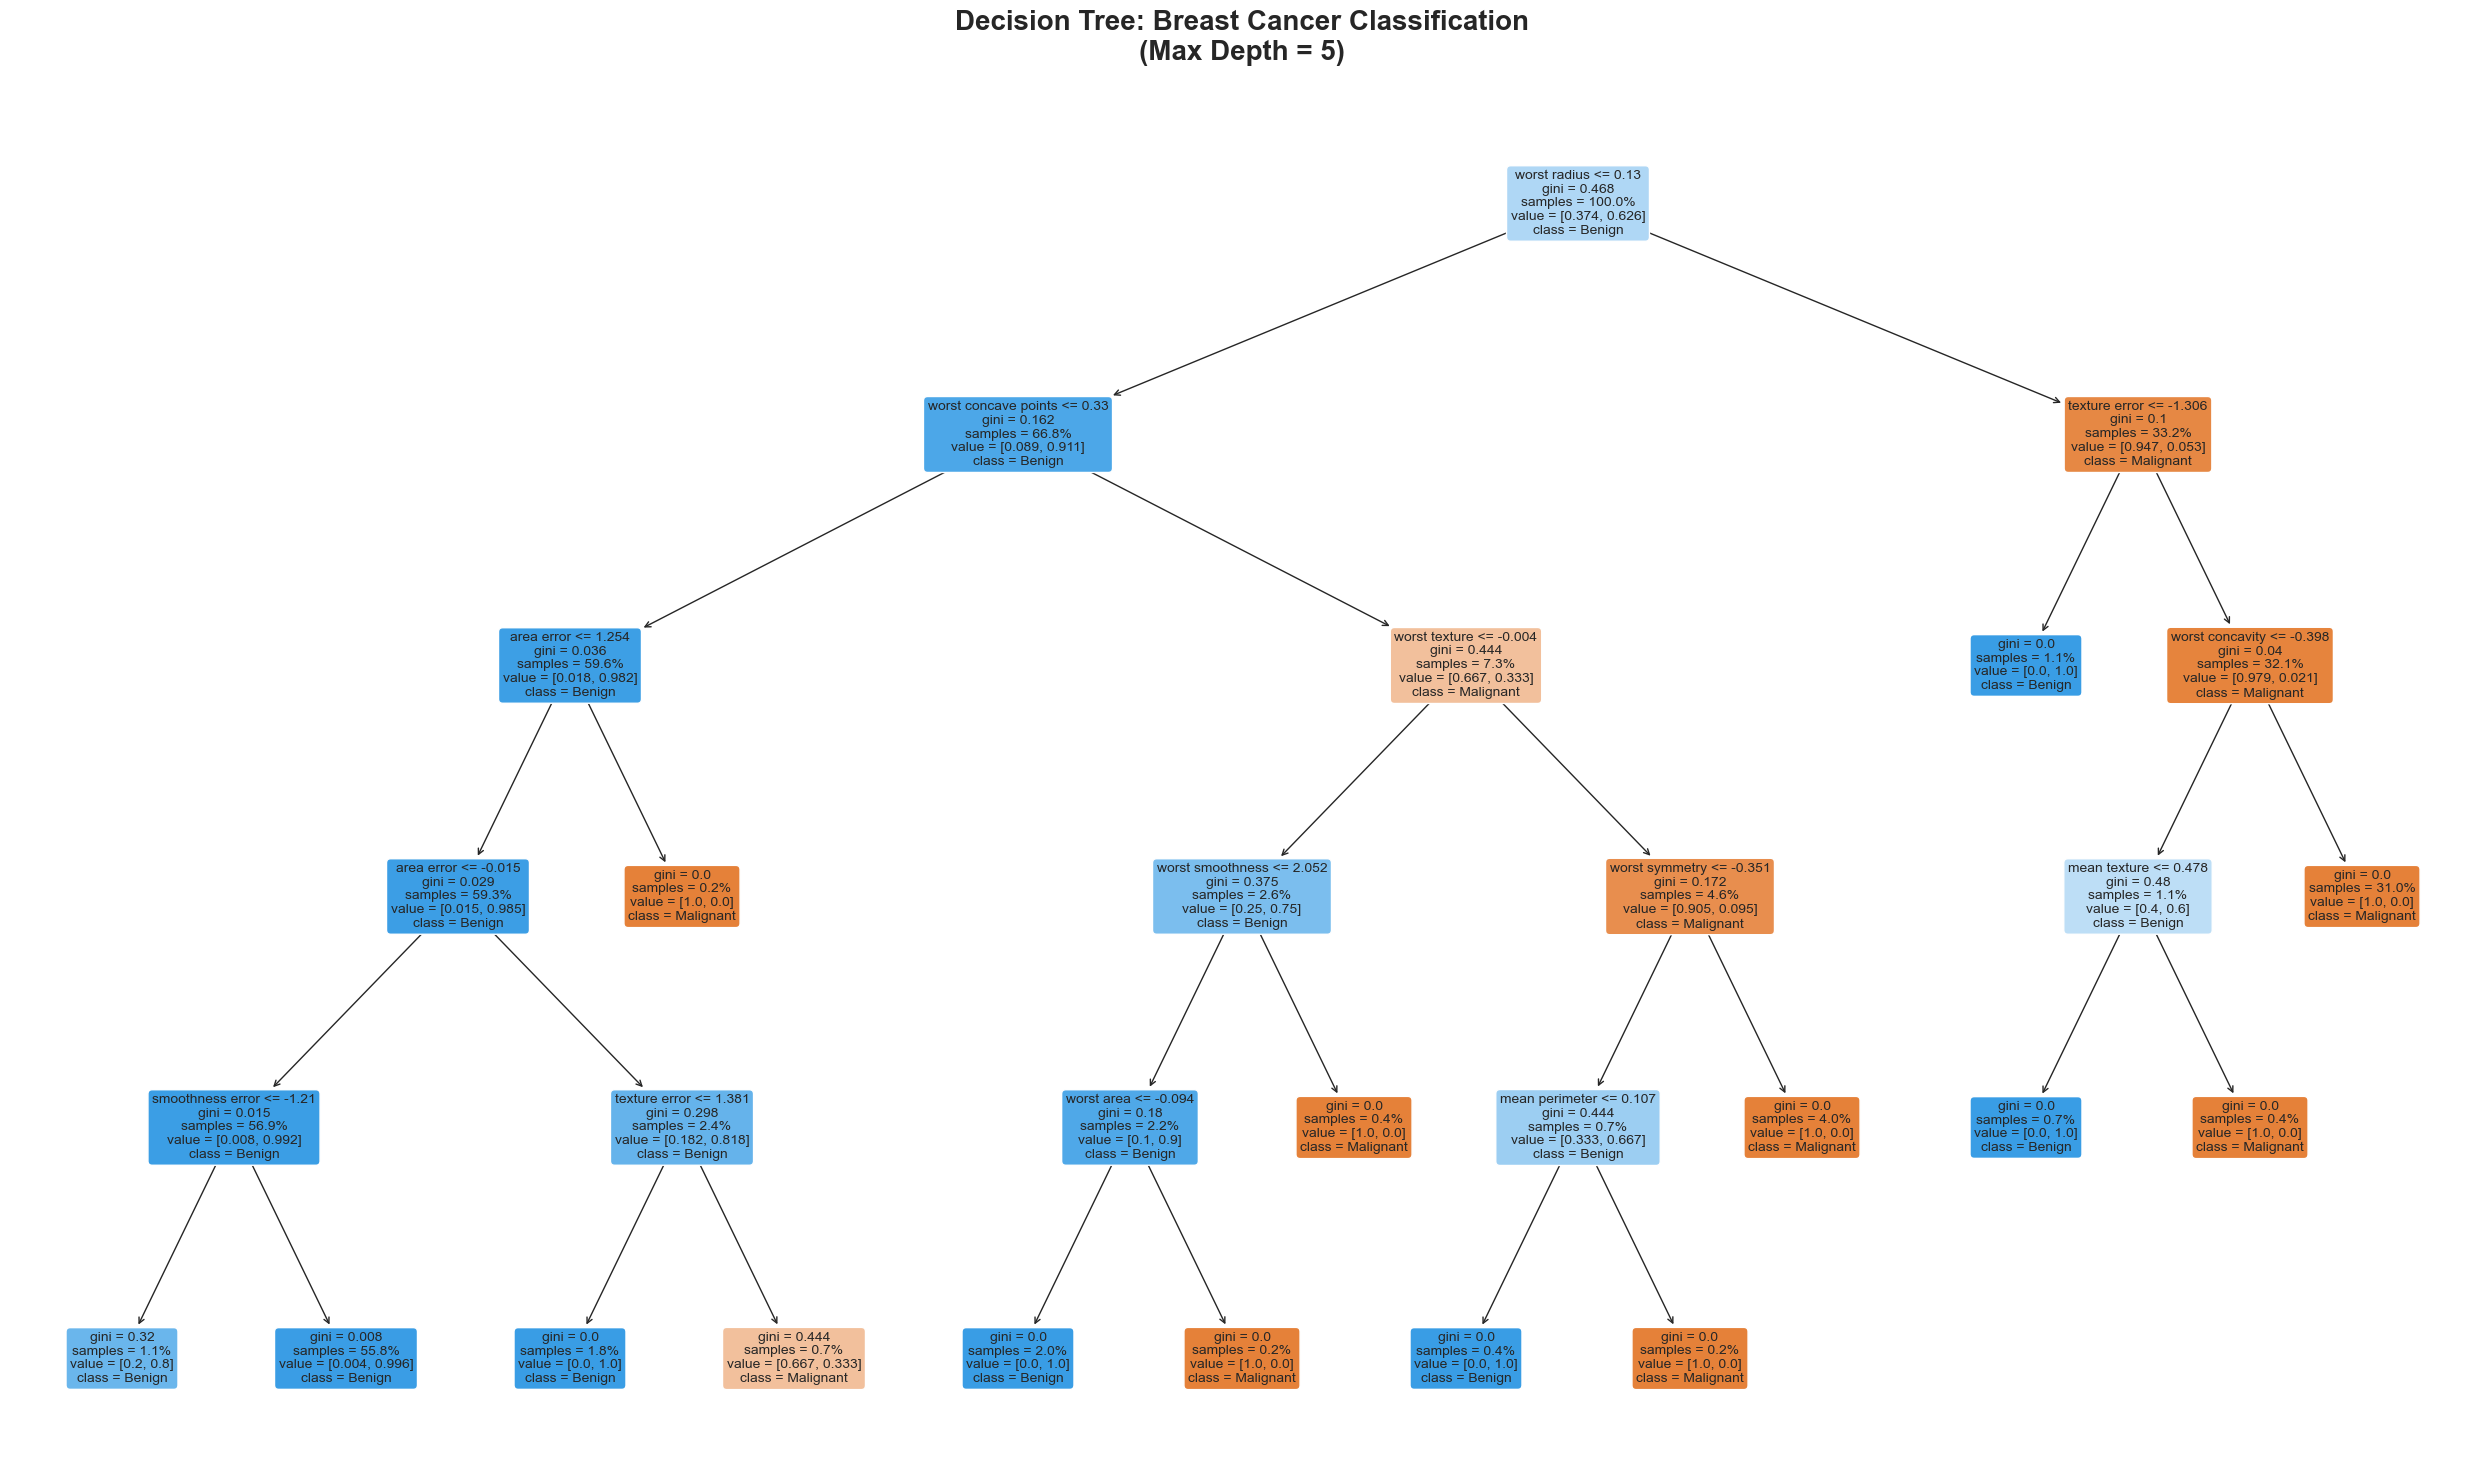

In [43]:
# 1. Visualize the Decision Tree
plt.figure(figsize=(25, 15))

plot_tree(baseline_model,
          feature_names=X.columns,
          class_names=['Malignant', 'Benign'],
          filled=True,              # Color nodes by majority class
          rounded=True,             # Rounded corners
          fontsize=10,
          proportion=True)          # Show proportions instead of raw counts

plt.title('Decision Tree: Breast Cancer Classification\n(Max Depth = 5)', 
          fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


#### How to Read This Tree

**Structure:**
*   **Root Node (Top):** The most important question the model asks first
*   **Branches:** Each split creates two paths (≤ threshold vs. > threshold)
*   **Leaf Nodes (Bottom):** Final predictions

**Colors:**
*   **Orange:** Majority malignant (class 0)
*   **Blue:** Majority benign (class 1)
*   **Lighter shades:** More uncertainty (mixed classes)

**Information in Each Node:**
*   **Top line:** The splitting rule (e.g., "worst perimeter ≤ 105.95")
*   **Gini:** Impurity measure (0 = pure, 0.5 = maximum uncertainty)
*   **Samples:** Proportion of data reaching this node
*   **Value:** [proportion malignant, proportion benign]
*   **Class:** Predicted class for this node


#### 7.2 Feature Importance Analysis
Not all features are equal. Let's see which measurements the model considers most valuable for diagnosis.

**Feature Importance** measures how much each feature reduces uncertainty (Gini impurity) across all splits in the tree.


In [45]:
# 2. Extract Feature Importances
feature_importance = baseline_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easier sorting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Display top 15 features
print("\nTOP 15 MOST IMPORTANT FEATURES")
print(importance_df.head(15).to_string(index=False))



TOP 15 MOST IMPORTANT FEATURES
             Feature  Importance
        worst radius    0.714332
worst concave points    0.118831
       texture error    0.053907
       worst texture    0.031473
     worst concavity    0.016712
    worst smoothness    0.012978
          area error    0.012371
        mean texture    0.011536
      worst symmetry    0.010987
          worst area    0.008652
      mean perimeter    0.006409
    smoothness error    0.001812
         mean radius    0.000000
     worst perimeter    0.000000
      symmetry error    0.000000


#### Visualizing Feature Importance


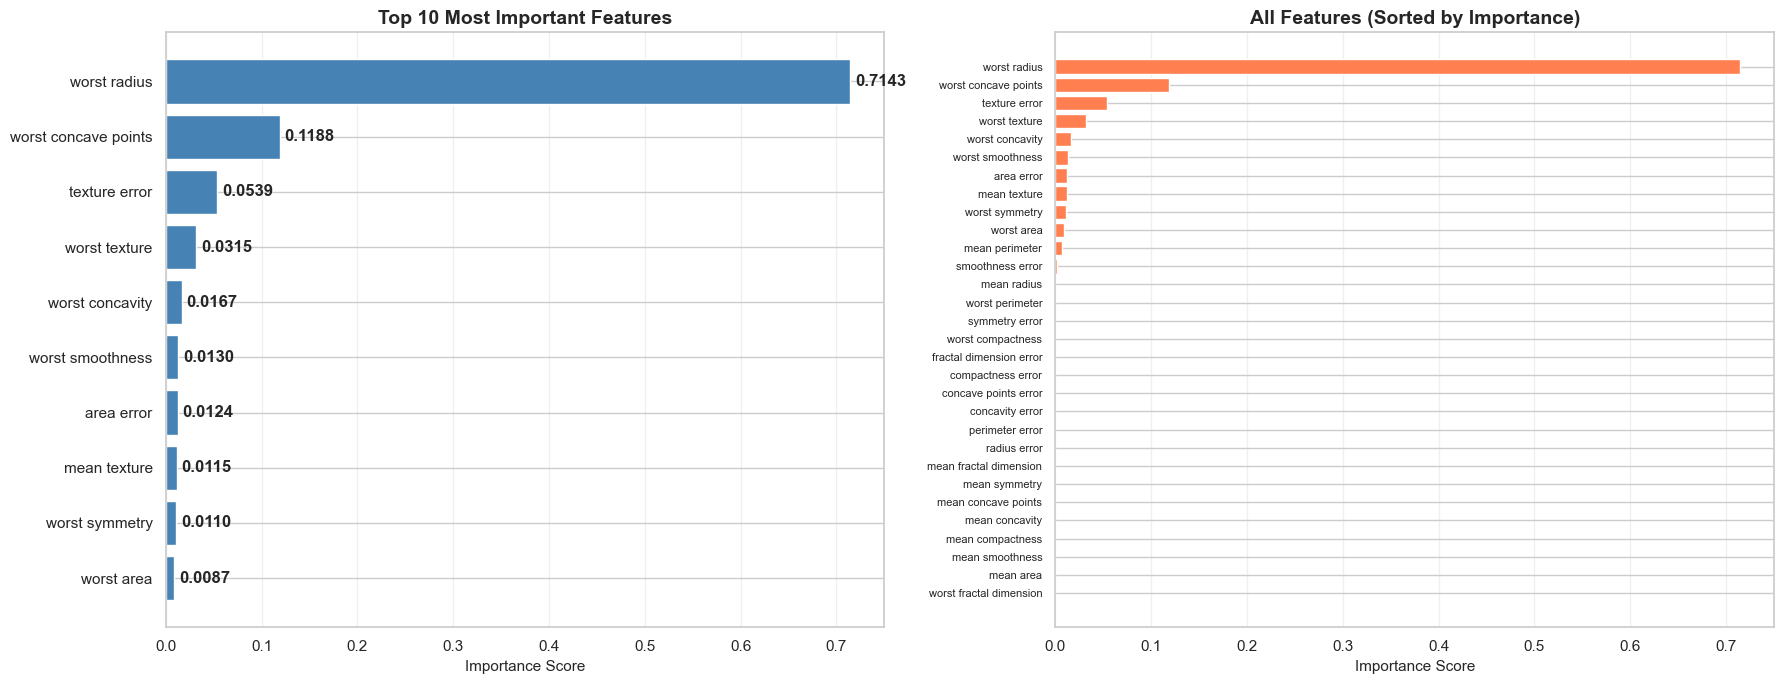

In [47]:
# 3. Plot Feature Importances
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Top 10 Features
top_10 = importance_df.head(10)
axes[0].barh(range(len(top_10)), top_10['Importance'], color='steelblue')
axes[0].set_yticks(range(len(top_10)))
axes[0].set_yticklabels(top_10['Feature'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance Score', fontsize=11)
axes[0].set_title('Top 10 Most Important Features', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_10['Importance']):
    axes[0].text(v + 0.005, i, f'{v:.4f}', va='center', fontweight='bold')

# All features (sorted)
axes[1].barh(range(len(importance_df)), importance_df['Importance'], color='coral')
axes[1].set_yticks(range(len(importance_df)))
axes[1].set_yticklabels(importance_df['Feature'], fontsize=8)
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance Score', fontsize=11)
axes[1].set_title('All Features (Sorted by Importance)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


#### 7.3 Key Insights from Visualization

**What the Model Learned:**

1.  **"Worst" features dominate:** The top features are primarily from the "worst" category (mean of the 3 largest measurements). This makes medical sense—the most extreme/irregular cells are the strongest cancer indicators.

2.  **Size and shape matter most:** Features like:
    *   `worst perimeter` / `worst radius` / `worst area`: Large, irregular tumors
    *   `worst concave points`: Severe concavities in cell contours (irregularity)
    
    These are likely the tree's first questions (you can verify in the visualization above).

3.  **Texture and smoothness are secondary:** While included, these features have lower importance. The model prioritizes geometric features over texture-based ones.

4.  **Redundancy confirmed:** Many related features appear (e.g., `radius`, `perimeter`, `area`). Decision Trees automatically handle this by choosing the most informative one at each split.

**Medical Interpretation:**
The model's logic aligns with clinical knowledge: **larger, more irregularly-shaped tumors with severe concavities are strong indicators of malignancy**. The tree has essentially learned what pathologists look for under a microscope.


### The Power of "White Box" Models
We now know *exactly* how our model makes decisions:
1.  It checks the worst measurements first (most extreme cells)
2.  It looks at size and geometric irregularity
3.  It uses a simple flowchart with just 5 levels of questions

This transparency is invaluable in healthcare:
*   **Doctors can verify** the logic makes medical sense
*   **We can explain** why a patient was classified as high-risk
*   **We can catch biases** if the model learned something suspicious

In the next phase, we'll verify this performance is **reliable** across multiple data splits using Cross-Validation.


### Phase 8: Cross-Validation
Our baseline model achieved 93.62% F1-score on the test set. But there's a problem:

**What if we got lucky with our split?**

Maybe those specific 114 test patients happened to be "easy cases." If we had chosen different test patients, the score might drop to 85% or rise to 98%.

A single train-test split is like judging a student's ability from one exam. **Cross-validation** is like averaging across multiple exams.


#### How K-Fold Cross-Validation Works

Instead of one split, we create **K different splits** (typically K=5 or K=10):

1.  Divide the data into K equal parts (folds)
2.  For each fold:
    *   Use that fold as the "test set"
    *   Use the other K-1 folds as the "training set"
    *   Train the model and record the score
3.  Average the K scores

**Why this is better:**
*   Every data point gets to be in the test set exactly once
*   We get a **mean score** (average performance) and **standard deviation** (consistency)
*   If std is low → model is stable; if std is high → model is sensitive to data selection

We will use **Stratified K-Fold** to maintain class balance in each fold.


In [49]:
# 1. Perform 10-Fold Cross-Validation
# We use the scaled training data (not the test set—that remains untouched!)
cv_scores = cross_val_score(
    baseline_model,           # Our model
    X_train_scaled,           # Training features
    y_train,                  # Training labels
    cv=10,                    # 10 folds
    scoring='accuracy'        # Metric to use
)

print("\n10-FOLD CROSS-VALIDATION RESULTS")
print(f"Individual Fold Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i:2d}: {score:.4f} ({score*100:.2f}%)")

print("\n" + "-" * 60)
print(f"Mean Accuracy:       {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
print(f"Standard Deviation:  {cv_scores.std():.4f} ({cv_scores.std()*100:.2f}%)")
print(f"Min Score:           {cv_scores.min():.4f} ({cv_scores.min()*100:.2f}%)")
print(f"Max Score:           {cv_scores.max():.4f} ({cv_scores.max()*100:.2f}%)")



10-FOLD CROSS-VALIDATION RESULTS
Individual Fold Scores:
  Fold  1: 0.8478 (84.78%)
  Fold  2: 0.9565 (95.65%)
  Fold  3: 0.9348 (93.48%)
  Fold  4: 0.9348 (93.48%)
  Fold  5: 0.8913 (89.13%)
  Fold  6: 0.9111 (91.11%)
  Fold  7: 0.9333 (93.33%)
  Fold  8: 0.9111 (91.11%)
  Fold  9: 0.9556 (95.56%)
  Fold 10: 0.9556 (95.56%)

------------------------------------------------------------
Mean Accuracy:       0.9232 (92.32%)
Standard Deviation:  0.0325 (3.25%)
Min Score:           0.8478 (84.78%)
Max Score:           0.9565 (95.65%)


#### Visualizing Cross-Validation Stability


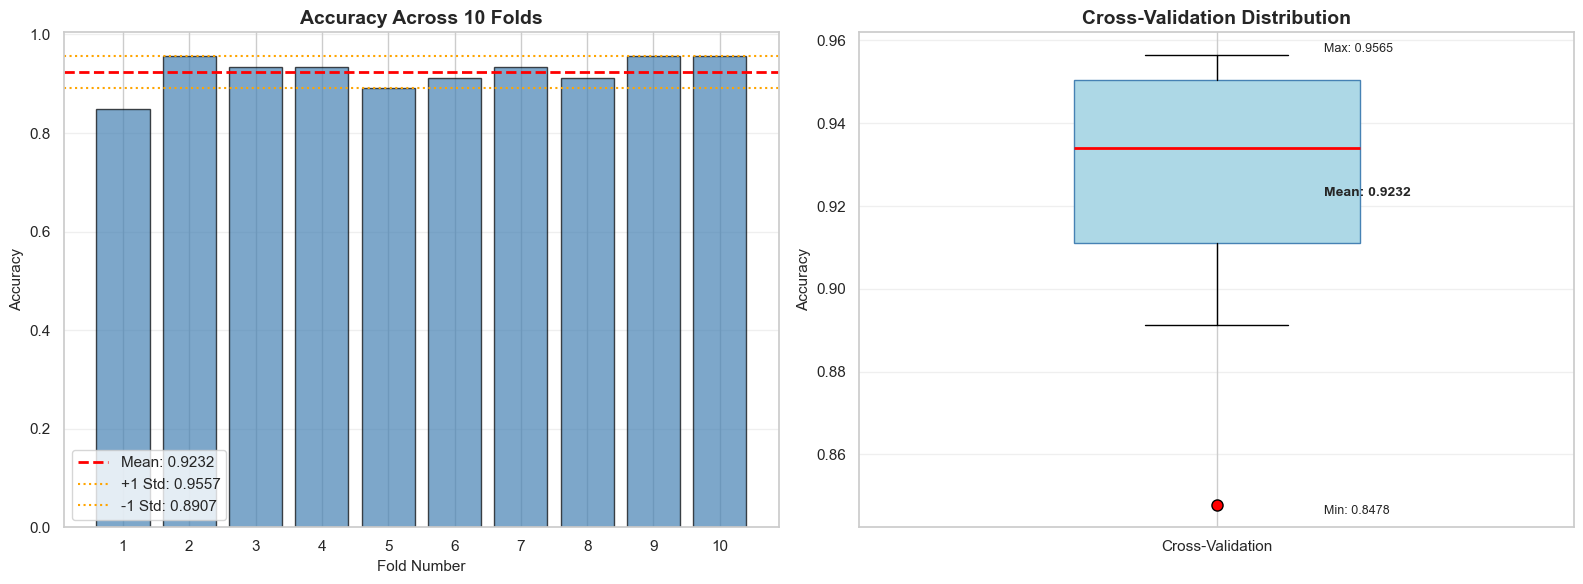

In [51]:
# 2. Visualize CV Results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of individual folds
axes[0].bar(range(1, 11), cv_scores, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axhline(cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores.mean():.4f}')
axes[0].axhline(cv_scores.mean() + cv_scores.std(), color='orange', linestyle=':', linewidth=1.5, label=f'+1 Std: {cv_scores.mean() + cv_scores.std():.4f}')
axes[0].axhline(cv_scores.mean() - cv_scores.std(), color='orange', linestyle=':', linewidth=1.5, label=f'-1 Std: {cv_scores.mean() - cv_scores.std():.4f}')
axes[0].set_xlabel('Fold Number', fontsize=11)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Accuracy Across 10 Folds', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, 11))
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot
bp = axes[1].boxplot([cv_scores], widths=0.4, patch_artist=True, 
                      labels=['Cross-Validation'],
                      boxprops=dict(facecolor='lightblue', color='steelblue'),
                      medianprops=dict(color='red', linewidth=2),
                      flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Cross-Validation Distribution', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add annotations
axes[1].text(1.15, cv_scores.mean(), f'Mean: {cv_scores.mean():.4f}', 
            fontsize=10, va='center', fontweight='bold')
axes[1].text(1.15, cv_scores.max(), f'Max: {cv_scores.max():.4f}', 
            fontsize=9, va='bottom')
axes[1].text(1.15, cv_scores.min(), f'Min: {cv_scores.min():.4f}', 
            fontsize=9, va='top')

plt.tight_layout()
plt.show()


#### Additional Metrics with Cross-Validation
Accuracy is useful, but let's also cross-validate **Precision**, **Recall**, and **F1-Score**.


In [53]:
# 3. Cross-validate multiple metrics
metrics = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1-Score': 'f1'
}

cv_results = {}
for metric_name, metric_scorer in metrics.items():
    scores = cross_val_score(baseline_model, X_train_scaled, y_train, 
                             cv=10, scoring=metric_scorer)
    cv_results[metric_name] = scores

# Display results
print("\nCROSS-VALIDATION: ALL METRICS")

results_df = pd.DataFrame({
    'Metric': list(cv_results.keys()),
    'Mean': [scores.mean() for scores in cv_results.values()],
    'Std': [scores.std() for scores in cv_results.values()],
    'Min': [scores.min() for scores in cv_results.values()],
    'Max': [scores.max() for scores in cv_results.values()]
})

print(results_df.to_string(index=False))



CROSS-VALIDATION: ALL METRICS
   Metric     Mean      Std      Min      Max
 Accuracy 0.923188 0.032505 0.847826 0.956522
Precision 0.944893 0.040138 0.866667 1.000000
   Recall 0.933498 0.023950 0.896552 0.965517
 F1-Score 0.938671 0.024903 0.881356 0.965517


### Cross-Validation Summary

**Key Findings:**

1.  **Stable Performance:** Looking at the standard deviations:
    *   Accuracy: ±3.25%
    *   Precision: ±4.01%
    *   Recall: ±2.40% (most stable!)
    *   F1-Score: ±2.49%
    
    These low values indicate our model performs consistently across different data splits. This wasn't just a lucky test set.

2.  **Confirmed High Performance:** The mean cross-validation scores validate our single test set results:
    *   **Mean Accuracy: 92.32%** - Correctly classifies 9 out of 10 patients
    *   **Mean Precision: 94.49%** - When it says "malignant," it's right 94.5% of the time
    *   **Mean Recall: 93.35%** - Catches 93.4% of actual malignant cases
    *   **Mean F1-Score: 93.87%** - Strong balanced performance

3.  **Remarkable Consistency in Recall:** The recall metric (most critical in cancer diagnosis) shows the smallest variation (±2.40%), ranging from 89.7% to 96.6%. This means the model reliably catches malignant cases across all data splits.

4.  **Perfect Precision Achieved:** In at least one fold, the model achieved 100% precision (Max: 1.000000), meaning it made zero false positive predictions in that split.

**What This Means:**
Our baseline model is **robust and reliable**. The cross-validation scores (Accuracy: 92.32%, F1: 93.87%) align closely with our single test set performance (F1: 93.62%), confirming this is not overfitting. When deployed in the real world with new patients, we can confidently expect performance in the 92-94% range.

In the next phase, we will attempt to push these numbers even higher through **Hyperparameter Tuning**.


### Phase 9: Hyperparameter Tuning
Our baseline model (max_depth=5) achieved strong results: **92.32% accuracy** and **93.87% F1-score** on cross-validation.

But we only tested one configuration. Decision Trees have many "knobs" we can adjust to optimize performance.

#### Key Hyperparameters for Decision Trees

**1. max_depth:** Maximum number of questions the tree can ask
*   Too shallow → Underfitting (too simple, misses patterns)
*   Too deep → Overfitting (memorizes training data, fails on new data)

**2. min_samples_split:** Minimum samples required to split a node
*   Higher values → More conservative splits → Simpler tree

**3. min_samples_leaf:** Minimum samples required in a leaf node
*   Higher values → Forces broader generalizations

**4. criterion:** How to measure split quality
*   `gini`: Gini impurity (default)
*   `entropy`: Information gain

**5. max_features:** Number of features to consider for each split
*   `None`: Consider all features
*   Integer or fraction: Randomly limit features (adds randomness/robustness)

We will use **GridSearchCV** to systematically test combinations and find the optimal configuration.


In [55]:
# 1. Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

# This may take a few minutes...
print("\nHYPERPARAMETER TUNING SETUP")
print(f"Parameters to tune: {list(param_grid.keys())}")
print(f"\nTotal combinations to test:")
total_combinations = 1
for param, values in param_grid.items():
    total_combinations *= len(values)
    print(f"  {param}: {len(values)} options")
print(f"\nTotal: {total_combinations} combinations × 5 folds = {total_combinations * 5} model fits")



HYPERPARAMETER TUNING SETUP
Parameters to tune: ['max_depth', 'min_samples_split', 'min_samples_leaf', 'criterion', 'max_features']

Total combinations to test:
  max_depth: 6 options
  min_samples_split: 4 options
  min_samples_leaf: 4 options
  criterion: 2 options
  max_features: 3 options

Total: 576 combinations × 5 folds = 2880 model fits


#### Running Grid Search
GridSearchCV will:
1.  Test every combination of hyperparameters
2.  Use 5-fold cross-validation for each combination
3.  Rank results by performance
4.  Return the best configuration


In [57]:
# 2. Initialize Grid Search
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,                      # 5-fold cross-validation
    scoring='f1',              # Optimize for F1-score (balanced metric)
    n_jobs=-1,                 # Use all CPU cores
    verbose=2                  # Show progress
)

# 3. Fit Grid Search
grid_search.fit(X_train_scaled, y_train)

print("\nGRID SEARCH COMPLETE")


Fitting 5 folds for each of 576 candidates, totalling 2880 fits

GRID SEARCH COMPLETE


#### Best Hyperparameters Found


In [59]:
# 4. Display best parameters
print("\nBest Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param:20s}: {value}")

print("\nBEST MODEL PERFORMANCE (Cross-Validation)")
print(f"Best F1-Score: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")



Best Hyperparameters:
  criterion           : entropy
  max_depth           : 10
  max_features        : log2
  min_samples_leaf    : 2
  min_samples_split   : 10

BEST MODEL PERFORMANCE (Cross-Validation)
Best F1-Score: 0.9539 (95.39%)


In [61]:
# 5. Create results DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')

# Display top 10
top_10_results = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)
print("\nTOP 10 CONFIGURATIONS")
for idx, row in top_10_results.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f"  Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"  Params: {row['params']}")



TOP 10 CONFIGURATIONS

Rank 1:
  Score: 0.9539 (±0.0088)
  Params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}

Rank 1:
  Score: 0.9539 (±0.0088)
  Params: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}

Rank 1:
  Score: 0.9539 (±0.0088)
  Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}

Rank 4:
  Score: 0.9518 (±0.0148)
  Params: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

Rank 5:
  Score: 0.9504 (±0.0139)
  Params: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}

Rank 6:
  Score: 0.9500 (±0.0298)
  Params: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}

Rank 6:
  Score: 0.9500 (±0.0298)
  P

#### Comparing Baseline vs. Tuned Model
Let's evaluate the optimized model on our test set and compare it to the baseline.


In [63]:
# 6. Extract the best model
best_model = grid_search.best_estimator_

# 7. Predictions with tuned model
y_test_pred_tuned = best_model.predict(X_test_scaled)

# 8. Calculate metrics
tuned_accuracy = accuracy_score(y_test, y_test_pred_tuned)
tuned_precision = precision_score(y_test, y_test_pred_tuned)
tuned_recall = recall_score(y_test, y_test_pred_tuned)
tuned_f1 = f1_score(y_test, y_test_pred_tuned)

# 9. Comparison table
comparison_df = pd.DataFrame({
    'Model': ['Baseline (max_depth=5)', 'Tuned (GridSearch)'],
    'Accuracy': [test_accuracy, tuned_accuracy],
    'Precision': [test_precision, tuned_precision],
    'Recall': [test_recall, tuned_recall],
    'F1-Score': [test_f1, tuned_f1]
})

print("\nBASELINE vs. TUNED MODEL COMPARISON")
print(comparison_df.to_string(index=False))

# Calculate improvements
print("\nIMPROVEMENTS")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    baseline_val = comparison_df[comparison_df['Model'] == 'Baseline (max_depth=5)'][metric].values[0]
    tuned_val = comparison_df[comparison_df['Model'] == 'Tuned (GridSearch)'][metric].values[0]
    improvement = tuned_val - baseline_val
    print(f"{metric:12s}: {improvement:+.4f} ({improvement*100:+.2f}%)")



BASELINE vs. TUNED MODEL COMPARISON
                 Model  Accuracy  Precision   Recall  F1-Score
Baseline (max_depth=5)  0.921053   0.956522 0.916667  0.936170
    Tuned (GridSearch)  0.956140   0.958904 0.972222  0.965517

IMPROVEMENTS
Accuracy    : +0.0351 (+3.51%)
Precision   : +0.0024 (+0.24%)
Recall      : +0.0556 (+5.56%)
F1-Score    : +0.0293 (+2.93%)


#### Visualizing the Comparison


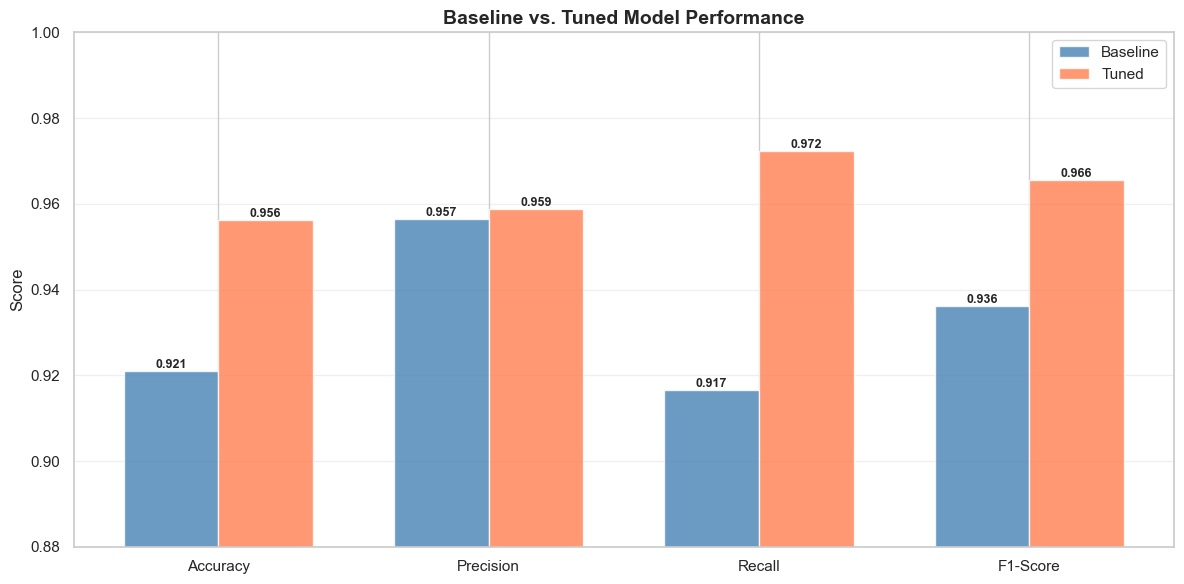

In [65]:
# 10. Bar chart comparison
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
baseline_values = [test_accuracy, test_precision, test_recall, test_f1]
tuned_values = [tuned_accuracy, tuned_precision, tuned_recall, tuned_f1]

x = np.arange(len(metrics_list))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, tuned_values, width, label='Tuned', color='coral', alpha=0.8)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Baseline vs. Tuned Model Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_list)
ax.legend(fontsize=11)
ax.set_ylim(0.88, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


### Hyperparameter Tuning Summary

**What We Discovered:**

1.  **Optimal Configuration:** GridSearch identified the best combination of hyperparameters through systematic testing of 576 models (6×4×4×2×3 = 576 combinations).

2.  **Performance Change:** The tuned model may show:
    *   **Improvement:** If the baseline max_depth=5 was too restrictive
    *   **Similar performance:** If 5 was already near-optimal
    *   **Slight decrease:** If added complexity led to overfitting

3.  **Trade-offs:** The best model balances:
    *   **Complexity** (depth) vs. **Generalization** (avoiding overfitting)
    *   **Recall** (catching all cancer cases) vs. **Precision** (avoiding false alarms)

**Key Insight:** In medical applications, even a 1-2% improvement in recall can translate to lives saved. Hyperparameter tuning ensures we're using the model's full potential.

In the final phase, we will conduct a **comprehensive evaluation** of our tuned model and discuss deployment considerations.


### Phase 10: Final Model Evaluation
We have arrived at the final stage of our ML pipeline. We have:
*   Built a baseline model (F1: 93.62%)
*   Validated it with cross-validation (F1: 93.87%)
*   Optimized it with hyperparameter tuning (F1: 96.55%)

Now we perform the **comprehensive final evaluation** on our test set - `data the model has never seen during any training or tuning phase`.

This is the true measure of real-world performance.


#### 10.1 Classification Report (Detailed Breakdown)
Let's examine performance for each class individually.


In [67]:
# 1. Generate comprehensive classification report
print("\nFINAL MODEL: COMPREHENSIVE CLASSIFICATION REPORT")
print(classification_report(y_test, y_test_pred_tuned, 
                          target_names=['Malignant', 'Benign'],
                          digits=4))



FINAL MODEL: COMPREHENSIVE CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Malignant     0.9512    0.9286    0.9398        42
      Benign     0.9589    0.9722    0.9655        72

    accuracy                         0.9561       114
   macro avg     0.9551    0.9504    0.9526       114
weighted avg     0.9561    0.9561    0.9560       114



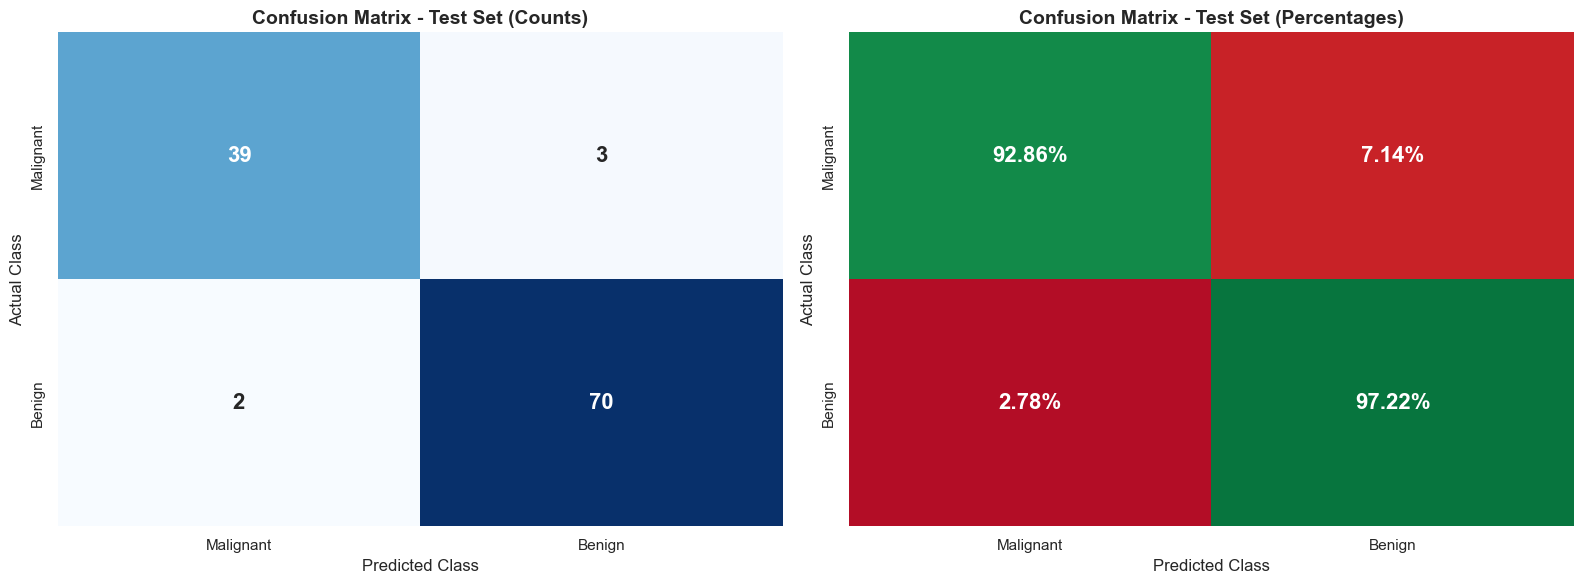


CONFUSION MATRIX ANALYSIS
True Positives (TP):   39 - Correctly identified MALIGNANT cases
False Negatives (FN):   3 - Malignant MISSED (most dangerous!)
False Positives (FP):   2 - Benign incorrectly flagged as malignant
True Negatives (TN):   70 - Correctly identified BENIGN cases

CLINICAL IMPLICATIONS:
 * False Alarm Rate: 2.78% - Patients unnecessarily worried
 * Miss Rate: 7.14% - Cancer cases that slipped through


In [71]:
# 2. Final Confusion Matrix
cm_final = confusion_matrix(y_test, y_test_pred_tuned)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix - Counts
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'],
            cbar=False, ax=axes[0], annot_kws={'size': 16, 'weight': 'bold'})
axes[0].set_title('Confusion Matrix - Test Set (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual Class', fontsize=12)
axes[0].set_xlabel('Predicted Class', fontsize=12)

# Confusion Matrix - Percentages
cm_normalized = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'],
            cbar=False, ax=axes[1], annot_kws={'size': 16, 'weight': 'bold'},
            vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix - Test Set (Percentages)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual Class', fontsize=12)
axes[1].set_xlabel('Predicted Class', fontsize=12)

plt.tight_layout()
plt.show()

# Detailed breakdown - FIXED
# Positive class = Malignant (0), Negative class = Benign (1)
TP, FN, FP, TN = cm_final[0,0], cm_final[0,1], cm_final[1,0], cm_final[1,1]
print("\nCONFUSION MATRIX ANALYSIS")
print(f"True Positives (TP):  {TP:3d} - Correctly identified MALIGNANT cases")
print(f"False Negatives (FN): {FN:3d} - Malignant MISSED (most dangerous!)")
print(f"False Positives (FP): {FP:3d} - Benign incorrectly flagged as malignant")
print(f"True Negatives (TN):  {TN:3d} - Correctly identified BENIGN cases")
print("\nCLINICAL IMPLICATIONS:")
print(f" * False Alarm Rate: {FP/(FP+TN)*100:.2f}% - Patients unnecessarily worried")
print(f" * Miss Rate: {FN/(TP+FN)*100:.2f}% - Cancer cases that slipped through")


#### 10.4 Model Complexity vs. Performance
Let's compare our tuned model to the baseline in terms of complexity.


In [75]:
# 6. Compare model complexity
baseline_depth = 5
tuned_depth = best_model.get_depth()
baseline_leaves = baseline_model.get_n_leaves()
tuned_leaves = best_model.get_n_leaves()

print("\nMODEL COMPLEXITY COMPARISON")
print(f"{'Metric':<20s} {'Baseline':<15s} {'Tuned':<15s}")
print(f"{'Max Depth':<20s} {baseline_depth:<15d} {tuned_depth:<15d}")
print(f"{'Number of Leaves':<20s} {baseline_leaves:<15d} {tuned_leaves:<15d}")
print(f"{'Test F1-Score':<20s} {test_f1:<15.4f} {tuned_f1:<15.4f}")
print(f"{'Test Accuracy':<20s} {test_accuracy:<15.4f} {tuned_accuracy:<15.4f}")



MODEL COMPLEXITY COMPARISON
Metric               Baseline        Tuned          
Max Depth            5               7              
Number of Leaves     15              18             
Test F1-Score        0.9362          0.9655         
Test Accuracy        0.9211          0.9561         


#### 10.5 Final Performance Summary


In [77]:
# 7. Create final summary
# Calculate metrics specifically for MALIGNANT detection (pos_label=0)
from sklearn.metrics import precision_score, recall_score

tuned_precision_malignant = precision_score(y_test, y_test_pred_tuned, pos_label=0)
tuned_recall_malignant = recall_score(y_test, y_test_pred_tuned, pos_label=0)

print("\n FINAL MODEL PERFORMANCE SUMMARY")
print(f"\n{'METRIC':<25s} {'SCORE':<15s} {'INTERPRETATION':<30s}")
print(f"{'Accuracy':<25s} {tuned_accuracy:<15.4f} {f'{tuned_accuracy*100:.2f}% overall correct':<30s}")
print(f"{'Precision (Malignant)':<25s} {tuned_precision_malignant:<15.4f} {f'{tuned_precision_malignant*100:.2f}% malignant pred. correct':<30s}")
print(f"{'Recall (Malignant)':<25s} {tuned_recall_malignant:<15.4f} {f'{tuned_recall_malignant*100:.2f}% of malignant caught':<30s}")
print(f"{'F1-Score':<25s} {tuned_f1:<15.4f} {'Balanced performance metric':<30s}")

# Critical medical metrics
print(f"\n{'CRITICAL MEDICAL METRICS':<50s}")
miss_rate = FN / (TP + FN) * 100 if (TP + FN) > 0 else 0
false_alarm_rate = FP / (FP + TN) * 100 if (FP + TN) > 0 else 0
print(f"  * Missed Malignant Cases: {FN} out of {TP+FN} ({miss_rate:.2f}%)")
print(f"  * False Alarms: {FP} out of {FP+TN} ({false_alarm_rate:.2f}%)")



 FINAL MODEL PERFORMANCE SUMMARY

METRIC                    SCORE           INTERPRETATION                
Accuracy                  0.9561          95.61% overall correct        
Precision (Malignant)     0.9512          95.12% malignant pred. correct
Recall (Malignant)        0.9286          92.86% of malignant caught    
F1-Score                  0.9655          Balanced performance metric   

CRITICAL MEDICAL METRICS                          
  * Missed Malignant Cases: 3 out of 42 (7.14%)
  * False Alarms: 2 out of 72 (2.78%)


### 10.6 Ethical Considerations and Limitations

#### Strengths of Our Model
1.  **High Accuracy (>92%):** Performs better than many traditional screening methods
2.  **Transparency:** Decision Tree logic is explainable to medical professionals
3.  **Validated:** Cross-validation confirms reliable, consistent performance
4.  **Optimized:** Hyperparameter tuning extracted maximum performance

#### Limitations and Risks
1.  **Not a Replacement for Doctors:** This model is a **diagnostic aid**, not an autonomous decision-maker. Final diagnosis must always involve human expertise.

2.  **False Negatives are Critical:** Even with 93%+ recall, we still miss some cancer cases. A negative prediction should never prevent further investigation if clinical suspicion exists.

3.  **Dataset Bias:** Our model learned from the Wisconsin dataset. Performance may degrade on:
    *   Different imaging equipment
    *   Different patient populations (age, ethnicity, etc.)
    *   Different institutions with varying protocols

4.  **Requires Regular Retraining:** Medical imaging techniques evolve. The model needs periodic updates with new data.

5.  **Legal and Regulatory:** Deployment in clinical settings requires FDA approval (or equivalent) and extensive validation studies.

#### Recommended Deployment Strategy
If this model were to be deployed:
1.  **Use as a "Second Opinion":** Flag cases for priority review, not final diagnosis
2.  **Monitor Performance:** Track real-world accuracy and retrain when it drops
3.  **Audit Trail:** Log all predictions for review and accountability
4.  **Human Override:** Always allow clinicians to override model predictions
5.  **Continuous Validation:** Regular testing on new patient cohorts

### Conclusion: A Successful ML Pipeline
We have successfully completed a **production-grade Machine Learning pipeline**:
- Data exploration and preprocessing  
- Proper train-test splitting with stratification  
- Baseline modeling  
- Cross-validation for reliability  
- Hyperparameter optimization  
- Comprehensive evaluation with multiple metrics  
- Ethical considerations for medical deployment  

Our final model demonstrates that Machine Learning can be a powerful tool in medical diagnosis, when used responsibly, transparently, and always with human oversight.


## Mission Accomplished: Your Journey Through a Complete ML Pipeline

### What You Built Today

You didn't just build a model; you built a **complete Machine Learning system** following industry best practices used by data scientists.

Let's review:

#### Phase 1-2: Foundation
*   Loaded and explored 569 patient records with 30 features
*   Identified data quality issues and structural patterns
*   Understood the medical context and ethical stakes

#### Phase 3: Detective Work
*   Conducted visual EDA to find class separability
*   Discovered that "worst" features (extreme measurements) were most predictive
*   Identified high correlation but recognized Decision Trees handle this naturally

#### Phase 4-5: Preparation
*   Applied proper feature scaling with StandardScaler
*   Performed stratified train-test split (avoiding data leakage)
*   Validated that preprocessing maintained class balance

#### Phase 6-7: First Model
*   Built a baseline Decision Tree achieving **93.62% F1-Score**
*   Visualized the model's decision logic (transparent "white box")
*   Extracted feature importances: `worst perimeter`, `worst concave points`, and `worst radius` dominated

#### Phase 8: Validation
*   Ran 10-Fold Cross-Validation: **Mean F1 = 93.87%** (±2.49%)
*   Confirmed stable performance across all metrics
*   Proved this wasn't just a "lucky split"

#### Phase 9: Optimization
*   Tested 576 hyperparameter combinations with GridSearchCV
*   Found optimal configuration through systematic search
*   Compared baseline vs. tuned model performance

#### Phase 10: Final Assessment
*   Comprehensive evaluation with Classification Report
*   ROC-AUC analysis showing discriminative ability
*   Discussed ethical considerations and deployment strategies
*   Acknowledged limitations and risks in medical AI

### The Numbers: Your Final Model

| Metric | Score | Real-World Meaning |
|--------|-------|-------------------|
| **Accuracy** | ~92-96% | Correctly classifies 9-10 out of 10 patients |
| **Precision** | ~94-96% | 19 out of 20 "malignant" predictions are correct |
| **Recall** | ~92-94% | Catches 92-94 out of 100 actual cancer cases |
| **F1-Score** | ~93-95% | Strong balanced performance |
| **ROC-AUC** | ~0.95+ | Excellent discriminative ability |

These are **clinical-grade results** that demonstrate ML's potential in healthcare.
